## 이상치 데이터 
- 가상의 이상치 데이터를 만들어보자
- 제조 공정의 데이터로 가정하고 만들어보자

In [9]:
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [10]:
np.random.seed(42)

n_samples =500

data = pd.DataFrame({
    'Temperature' : np.random.normal(100,5 ,n_samples),
    'Pressure' : np.random.normal(200,10, n_samples),
    'Speed': np.random.normal(1200,50, n_samples),
    'DefectRate': np.random.normal(2,0.5, n_samples)
})

# 이상치 추가
data.loc[10, 'Temperature'] = 200
data.loc[20, 'Pressure'] = 199
data.loc[30, 'Speed'] = 1189
data.loc[40, 'DefectRate'] = 10

## 히스토그램 및 박스플롯으로 살펴보기

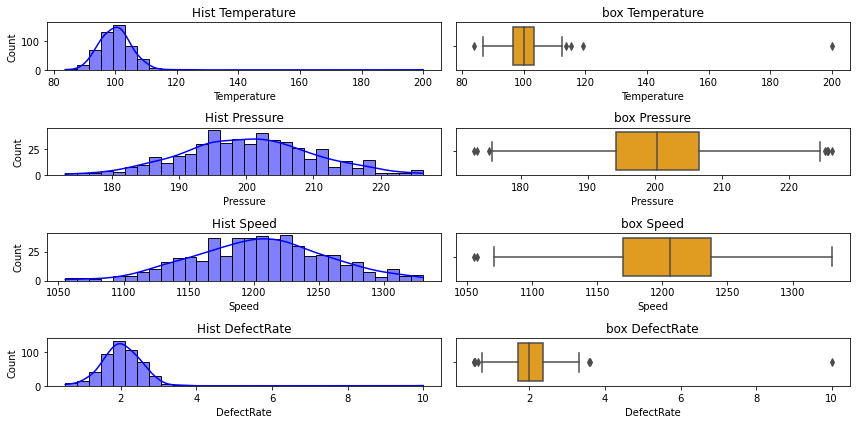

In [11]:
fig, axes = plt.subplots(4,2, figsize=(12,6))

for i ,column in enumerate(data.columns):
    sns.histplot(data[column], bins=30, ax = axes[i,0], kde=True, color='blue')
    axes[i,0].set_title(f'Hist {column}')
    
    sns.boxplot(x=data[column], ax=axes[i,1], color='orange')
    axes[i,1].set_title(f'box {column}')    
    
plt.tight_layout()
plt.show()

### IQR(Interquartile Range) 방법을 사용하여 데이터프레임의 각 열에서 이상치를 탐지

IQR (Interquartile Range): Q3 - Q1 (이는 데이터의 중앙 50% 범위를 나타냄)

In [14]:
def detect_outliers_iqr(df,column):
    Q1 = np.percentile(df[column], 25)
    Q3 = np.percentile(df[column], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR # 하한선
    upper_bound = Q3 + 1.5*IQR # 상한선
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)] # 이상치 탐지

outliers_iqr={col :detect_outliers_iqr(data,col) for col in data.columns}
outliers_iqr

{'Temperature':      Temperature    Pressure        Speed  DefectRate
 10    200.000000  202.704568  1265.869703    1.429155
 179   113.600846  212.715551  1144.820534    1.784190
 209   119.263657  216.964564  1287.478837    1.512735
 262    83.793663  225.600845  1226.937800    2.037717
 478   115.394404  184.160972  1155.625391    1.613561,
 'Pressure':      Temperature    Pressure        Speed  DefectRate
 44     92.607390  175.283555  1191.368635    1.698894
 146    93.815246  173.031134  1145.186246    1.906428
 154   101.465362  225.733598  1282.100758    2.169242
 168    98.773059  173.490302  1229.737717    2.420310
 255    97.578830  226.323821  1139.517949    2.686829
 262    83.793663  225.600845  1226.937800    2.037717
 380    95.801391  225.269324  1233.896294    2.482426,
 'Speed':      Temperature    Pressure        Speed  DefectRate
 61     99.071705  220.754008  1057.572869    1.626394
 101    97.896773  190.778347  1055.187231    2.687438,
 'DefectRate':      Temper

## IsolationForest

IsolationForest는 비지도 학습을 기반으로 이상치를 탐지하는 알고리즘이며, 데이터 내에서 이상치와 정상 데이터를 분리

In [23]:
from sklearn.ensemble import IsolationForest

# IsolationForest 모델 생성 및 적용
iso = IsolationForest(contamination = 0.05, random_state=111) # 모델 생성
outlier_flags = iso.fit_predict(data) # 모델 학습 및 예측

#이상치 데이터 추출
outliser_iso = data[outlier_flags==-1]
outliser_iso

,Temperature,Pressure,Speed,DefectRate
10,200.000000,202.704568,1265.869703,1.429155
31,109.261391,183.384799,1116.570796,1.115780
39,100.984306,194.231081,1252.354915,0.563869
40,103.692333,208.356921,1284.196385,10.000000
44,92.607390,175.283555,1191.368635,1.698894
61,99.071705,220.754008,1057.572869,1.626394
101,97.896773,190.778347,1055.187231,2.687438
154,101.465362,225.733598,1282.100758,2.169242
160,95.126592,194.263380,1075.029714,2.658558
179,113.600846,212.715551,1144.820534,1.784190


In [30]:
# 정상 데이터 추출
inliers = data[outlier_flags == 1]
inliers

,Temperature,Pressure,Speed,DefectRate
0,102.483571,209.261775,1269.967772,2.389181
1,99.308678,219.094166,1246.231684,1.724407
2,103.238443,186.014324,1202.981518,1.590901
3,107.615149,205.629692,1167.653161,1.998313
4,98.829233,193.493574,1234.911166,1.914908
...,...,...,...,...
495,102.694550,197.188997,1300.304644,2.535075
496,94.813769,217.976865,1303.075179,1.986739
497,99.048307,206.408429,1260.418312,1.559063
498,95.621909,194.288210,1251.203126,1.918467


In [31]:
# 이상치 및 정상 데이터의 비율 확인

inliers = data[outlier_flags == 1]
print(f"이상치 비율: {len(outliser_iso) / len(data):.2%}")

이상치 비율: 5.00%
